## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
from collections import defaultdict
from itertools import chain, combinations

### Importing datasets

In [2]:
parent_dir = 'ml-latest-small'
ratings = pd.read_csv(f'{parent_dir}/ratings.csv')
movies = pd.read_csv(f'{parent_dir}/movies.csv')

## Data Preprocessing

Task 1: Form transactional data set ⟨user id, {movies rated above 2}⟩ for users who rated more than 10 movies

In [3]:
# Filter users who rated more than 10 movies
user_ratings_count = ratings.groupby('userId').size()
user_ratings_count.head()

,0
userId,
1,232
2,29
3,39
4,216
5,44


In [4]:
users_gt_10_ratings = user_ratings_count[user_ratings_count > 10].index

In [5]:
len(users_gt_10_ratings)

610

In [6]:
# Filter ratings above 2 for those users
filtered_ratings = ratings[(ratings['userId'].isin(users_gt_10_ratings)) & (ratings['rating'] > 2)]

In [7]:
# Group the data by userId and create a list of movies rated above 2
transactional_data = filtered_ratings.groupby('userId')['movieId'].apply(list).reset_index()

In [8]:
transactional_data.head()

,userId,movieId
0,1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,..."
1,2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851..."
2,3,"[849, 1275, 1371, 1587, 2288, 2851, 3024, 3703..."
3,4,"[21, 45, 52, 58, 106, 125, 162, 171, 176, 215,..."
4,5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232..."


In [9]:
# Task 2: Divide the data set into 80% training and 20% test set
train_data = []
test_data = []

def split_movies(movies):
    # Split 80% for training and 20% for testing
    if len(movies) > 4:
        train_movies, test_movies = train_test_split(movies, test_size=0.2, random_state=42)
    else:
        # If only one movie, assign it all to train
        train_movies, test_movies = movies, []
    return train_movies, test_movies

# Split movies for each user
for i, row in transactional_data.iterrows():
    user_id = row['userId']
    movies = row['movieId']

    train_movies, test_movies = split_movies(movies)
    train_data.append({'userId': user_id, 'movieId': train_movies})
    if test_movies:
        test_data.append({'userId': user_id, 'movieId': test_movies})

# Convert train_data and test_data into DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Save the datasets to CSV
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("Training and test datasets have been created successfully!")

Training and test datasets have been created successfully!


## Association Rule Mining

In [10]:
# Load the training dataset
train_df = pd.read_csv('train_data.csv')
movies_df = pd.read_csv(f'{parent_dir}/movies.csv')  # Load movie metadata

In [11]:
train_df.head()

,userId,movieId
0,1,"[1136, 1031, 2054, 2090, 3450, 1270, 1408, 151..."
1,2,"[86345, 106782, 71535, 77455, 80489, 333, 6874..."
2,3,"[1587, 6835, 26409, 7991, 5764, 1371, 5181, 70..."
3,4,"[4273, 52, 2174, 3083, 1265, 3317, 937, 593, 3..."
4,5,"[608, 58, 474, 153, 261, 588, 592, 150, 300, 4..."


In [12]:
# convert string of list of movie ids to list
train_df['movieId'] = train_df['movieId'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [13]:
class Apriori:
    """Apriori Class that operates on sequence of transactions that are expected to be cleaned (should be in list format)"""
    def __init__(self, min_sup, output_dict_col_names, probs_true = False):
        self.min_sup = min_sup
        self.output_dict_col_names = output_dict_col_names
        self.probs_true = probs_true

    def _getFrequentItemsets(self, set_itemsets, transaction_list):
        """Return Frequent ItemSet and A dictionary with their Support."""
        set_freq_itemsets = set()
        itemsets_with_sup = defaultdict(int)
        freq_itemsets_with_sup = dict()

        # get itemset support count
        for itemset in set_itemsets:
            for transaction in transaction_list:
                if itemset.issubset(transaction): # check if the itemset is present in transaction
                    itemsets_with_sup[itemset] += 1

        # recognize those itemsets that are frequent
        trans_len = len(transaction_list)
        for itemset, sup_count in itemsets_with_sup.items():
            if sup_count/ trans_len >= self.min_sup:
                set_freq_itemsets.add(itemset)
                freq_itemsets_with_sup[itemset] = itemsets_with_sup[itemset]
                if self.probs_true:
                    freq_itemsets_with_sup[itemset] /= trans_len
        return set_freq_itemsets, freq_itemsets_with_sup

    def _getUnion(self, item_set, length):
        """Generating next-level candidate set from the current set of frequent itemsets"""
        return set([i.union(j) for i in item_set for j in item_set if len(i.union(j)) == length])

    def _pruning(self, candidate_set, prev_freq_set, length):
        """Applying the 'Anti-Monotonicity' rule to remove candidates with infrequent subsets"""
        temp_candidate_set = candidate_set.copy()
        for item in candidate_set:
            subsets = combinations(item, length)
            for subset in subsets:
                # if the subset is not in previous K-frequent get, then remove the set
                if frozenset(subset) not in prev_freq_set:
                    temp_candidate_set.remove(item)
                    break
        return temp_candidate_set

    def _generateL1Candidates(self, transaction_list):
        """Generate level-1 candidate set"""
        itemsets = set()

        for transaction in transaction_list:
            for item in transaction:
                itemsets.add(frozenset([item]))
        return itemsets

    def _dict_to_dataframe(self, dict_):
        """Convert nested dictionaries to dataframes"""
        data = []

        for _, vals in dict_.items():
            # Prepare dictionary for the current row
            req_dict = {
                self.output_dict_col_names[0]: list(vals.keys()),
                self.output_dict_col_names[1]: list(vals.values())
            }
            # Extend data list with rows from current dictionary
            data.extend(pd.DataFrame.from_dict(req_dict).to_dict(orient='records'))

        # Create DataFrame once from the collected data
        df = pd.DataFrame(data, columns=self.output_dict_col_names)
        return df


    def fit(self, transaction_list):
        """The driver function that returns the frequent itemset with their support count"""
        global_freq_itemsets_with_sup = dict()

        c1_set = self._generateL1Candidates(transaction_list) # set of candidates 1-itemsets
        # get L-1 frequent itemsets and their support counts
        l1_set, l1_set_with_sup = self._getFrequentItemsets(c1_set, transaction_list) # set of large 1-itemsets
        curr_lset = l1_set
        curr_lset_with_sup = l1_set_with_sup
        k = 2

        while curr_lset:
            global_freq_itemsets_with_sup[k-1] = curr_lset_with_sup
            candidate_set = self._getUnion(curr_lset, k) # self-joining Lk

            candidate_set = self._pruning(candidate_set, curr_lset, k-1)
            curr_lset, curr_lset_with_sup = self._getFrequentItemsets(candidate_set, transaction_list)
            k += 1

        return self._dict_to_dataframe(global_freq_itemsets_with_sup)

In [14]:
train_df['movieIdSet'] = train_df['movieId'].map(lambda x: set(x))

In [15]:
transaction_data = train_df['movieIdSet'].to_list()

In [16]:
min_sup = 50/ len(train_df)

apriori = Apriori(min_sup=min_sup, output_dict_col_names=['itemset', 'support'])
global_freq_itemsets_with_sup = apriori.fit(transaction_data)

In [17]:
global_freq_itemsets_with_sup.tail()

,itemset,support
1854,"(1210, 1196, 1036)",50
1855,"(260, 1210, 2571, 1196)",55
1856,"(5952, 4993, 7153, 318)",52
1857,"(5952, 7153, 4993, 2571)",50
1858,"(593, 356, 296, 318)",55


In [18]:
def proper_subset(s):
    """Construct all proper subsets of a given set"""
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

In [19]:
def getItemsetSupCount(itemset, transaction_list):
    """Get support count of itemset in transaction data"""
    if len(itemset) == 0:
        return 0

    sup_count = 0
    for transaction in transaction_list:
        if itemset.issubset(transaction): # check if the itemset is present in transaction
            sup_count += 1
    return sup_count

def associationRule(global_freq_itemsets_with_sup, transaction_list, min_threshold, output_columns):
    rules = []
    global_itemsets_with_sup = dict() # hashmap that would store support count of itemsets as they appear in the process
    for _, row in global_freq_itemsets_with_sup.iterrows():
        itemset = row['itemset']
        sup_count = row['support']
        # print(itemset, sup_count)
        for s in proper_subset(itemset):
            s = frozenset(s)
            if s not in global_itemsets_with_sup.keys():
                global_itemsets_with_sup[s] = getItemsetSupCount(s, transaction_list)

            if global_itemsets_with_sup[s] > 0:
                conf = sup_count/ global_itemsets_with_sup[s]
                if conf >= min_threshold:
                    rules.append([s, set(itemset.difference(s)), sup_count, conf])

    rules_df = pd.DataFrame(rules, columns=output_columns)
    return rules_df

In [43]:
# Step 2: Generate Association Rules from Frequent Itemsets
if not global_freq_itemsets_with_sup.empty:
    min_conf = 0.1  # Increase confidence to reduce the number of rules generated
    output_columns = ['antecedents', 'consequents', 'support',  'confidence']
    rules = associationRule(global_freq_itemsets_with_sup, transaction_data, min_threshold=min_conf, output_columns=output_columns)

    # Step 3: Filter rules where X (antecedent) contains only one movie
    single_antecedent_rules = rules[rules['antecedents'].apply(lambda x: len(x) == 1)]

    # Join with movie titles to make it interpretable
    def get_movie_titles(movie_ids):
        movie_titles = [movies_df[movies_df['movieId'] == movie_id]['title'].values[0] for movie_id in movie_ids]
        return ', '.join(movie_titles)

    single_antecedent_rules['antecedents'] = single_antecedent_rules['antecedents'].apply(get_movie_titles)
    single_antecedent_rules['consequents'] = single_antecedent_rules['consequents'].apply(get_movie_titles)

else:
    print(f"No frequent itemsets found with {min_sup} minimum support.")

<ipython-input-43-b65d03244d84>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_antecedent_rules['antecedents'] = single_antecedent_rules['antecedents'].apply(get_movie_titles)
<ipython-input-43-b65d03244d84>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_antecedent_rules['consequents'] = single_antecedent_rules['consequents'].apply(get_movie_titles)


### List of top 100 association rules ordered by support

In [44]:
top_100_rules_by_sup = single_antecedent_rules.sort_values(by='support', ascending=False).head(100)

# Print the top 5 rules in an interpretable format
print("Top 100 Association Rules by Support:")
for i, rule in top_100_rules_by_sup.iterrows():
    print(f"  If a user watches: {rule['antecedents']}")
    print(f"  Then re likely to watch: {rule['consequents']}")
    print(f"  Support: {rule['support']}, Confidence: {rule['confidence']:.4f}")
    print()

Top 100 Association Rules by Support:
  If a user watches: Pulp Fiction (1994)
  Then re likely to watch: Shawshank Redemption, The (1994)
  Support: 140, Confidence: 0.5983

  If a user watches: Shawshank Redemption, The (1994)
  Then re likely to watch: Pulp Fiction (1994)
  Support: 140, Confidence: 0.5600

  If a user watches: Forrest Gump (1994)
  Then re likely to watch: Shawshank Redemption, The (1994)
  Support: 131, Confidence: 0.5504

  If a user watches: Shawshank Redemption, The (1994)
  Then re likely to watch: Forrest Gump (1994)
  Support: 131, Confidence: 0.5240

  If a user watches: Forrest Gump (1994)
  Then re likely to watch: Pulp Fiction (1994)
  Support: 130, Confidence: 0.5462

  If a user watches: Pulp Fiction (1994)
  Then re likely to watch: Forrest Gump (1994)
  Support: 130, Confidence: 0.5556

  If a user watches: Silence of the Lambs, The (1991)
  Then re likely to watch: Pulp Fiction (1994)
  Support: 126, Confidence: 0.5833

  If a user watches: Pulp Fic

In [22]:
# Create the text file and write formatted rules to it
file_path = 'top_100_rules_by_sup.txt'

with open(file_path, 'w') as file:
    for index, rule in top_100_rules_by_sup.iterrows():
        rule_text = f"{rule['antecedents']} -> {rule['consequents']}"
        file.write(rule_text + '\n')

### List of top 100 association rules ordered by confidence

In [45]:
top_100_rules_by_conf = single_antecedent_rules.sort_values(by='confidence', ascending=False).head(100)

# Print the top 5 rules in an interpretable format
print("Top 100 Association Rules by Confidence:")
for i, rule in top_100_rules_by_conf.iterrows():
    print(f"  If a user watches: {rule['antecedents']}")
    print(f"  Then they are likely to watch: {rule['consequents']}")
    print(f"  Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}")
    print()

Top 100 Association Rules by Confidence:
  If a user watches: Gattaca (1997)
  Then they are likely to watch: Matrix, The (1999)
  Support: 53.0000, Confidence: 0.7910

  If a user watches: Matrix Reloaded, The (2003)
  Then they are likely to watch: Matrix, The (1999)
  Support: 56.0000, Confidence: 0.7887

  If a user watches: Batman Forever (1995)
  Then they are likely to watch: Batman (1989)
  Support: 71.0000, Confidence: 0.7802

  If a user watches: Godfather: Part II, The (1974)
  Then they are likely to watch: Godfather, The (1972)
  Support: 74.0000, Confidence: 0.7789

  If a user watches: Fifth Element, The (1997)
  Then they are likely to watch: Matrix, The (1999)
  Support: 68.0000, Confidence: 0.7727

  If a user watches: Star Wars: Episode I - The Phantom Menace (1999)
  Then they are likely to watch: Matrix, The (1999)
  Support: 61.0000, Confidence: 0.7722

  If a user watches: WALL·E (2008)
  Then they are likely to watch: Matrix, The (1999)
  Support: 57.0000, Confi

In [24]:
# Create the text file and write formatted rules to it
file_path = 'top_100_rules_by_conf.txt'

with open(file_path, 'w') as file:
    for index, rule in top_100_rules_by_conf.iterrows():
        rule_text = f"{rule['antecedents']} -> {rule['consequents']}"
        file.write(rule_text + '\n')

### Shared/Common Rules between the Two Lists

In [47]:
# Create a set of tuples for each DataFrame
sup_rules_set = set(zip(top_100_rules_by_sup['antecedents'], top_100_rules_by_sup['consequents']))
conf_rules_set = set(zip(top_100_rules_by_conf['antecedents'], top_100_rules_by_conf['consequents']))

# Find common rules using intersection
common_rules_set = sup_rules_set.intersection(conf_rules_set)

# Convert back to DataFrame for further processing or visualization
common_rules = pd.DataFrame(common_rules_set, columns=['antecedents', 'consequents'])

# Step: Merge common rules with the original single_antecedent_rules DataFrame to get confidence
common_rules_merged = pd.merge(
    common_rules,
    single_antecedent_rules[['antecedents', 'consequents', 'confidence']],
    on=['antecedents', 'consequents'],
    how='left'
)

# Sort the common rules by confidence
common_rules_sorted = common_rules_merged.sort_values(by='confidence', ascending=False)

# Display the final common rules sorted by confidence
common_rules_sorted[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
4,"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The...",0.753623
7,"Lord of the Rings: The Fellowship of the Ring,...","Lord of the Rings: The Return of the King, The...",0.724832
11,"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Fellowship of the Ring,...",0.724638
1,Star Wars: Episode V - The Empire Strikes Back...,Star Wars: Episode IV - A New Hope (1977),0.722222
8,"Lord of the Rings: The Return of the King, The...","Lord of the Rings: The Fellowship of the Ring,...",0.705882
2,"Sixth Sense, The (1999)","Matrix, The (1999)",0.698529
0,Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode IV - A New Hope (1977),0.696552
6,Saving Private Ryan (1998),"Matrix, The (1999)",0.684211
10,"Lord of the Rings: The Return of the King, The...","Lord of the Rings: The Two Towers, The (2002)",0.679739
3,"Lord of the Rings: The Fellowship of the Ring,...","Lord of the Rings: The Two Towers, The (2002)",0.671141


## Testing

In [49]:
# Step 2: Generate Association Rules from Frequent Itemsets
if not global_freq_itemsets_with_sup.empty:
    min_conf = 0.1  # Set minimum confidence threshold
    output_columns = ['antecedents', 'consequents', 'support', 'confidence']

    # Generate rules
    rules = associationRule(global_freq_itemsets_with_sup, transaction_data, min_threshold=min_conf, output_columns=output_columns)

    # Step 3: Filter rules where X (antecedent) contains only one movie
    single_antecedent_rules = rules[rules['antecedents'].apply(lambda x: len(x) == 1)]
else:
    print(f"No frequent itemsets found with {min_sup} minimum support.")

# Convert antecedents and consequents from set to tuple in the single_antecedent_rules DataFrame
single_antecedent_rules['antecedents'] = single_antecedent_rules['antecedents'].apply(tuple)
single_antecedent_rules['consequents'] = single_antecedent_rules['consequents'].apply(tuple)

# Get top 100 rules by support and confidence
top_100_rules_by_sup = single_antecedent_rules.sort_values(by='support', ascending=False).head(100)
top_100_rules_by_conf = single_antecedent_rules.sort_values(by='confidence', ascending=False).head(100)

# Create a set of tuples for each DataFrame (antecedents and consequents are already tuples)
sup_rules_set = set(zip(top_100_rules_by_sup['antecedents'], top_100_rules_by_sup['consequents']))
conf_rules_set = set(zip(top_100_rules_by_conf['antecedents'], top_100_rules_by_conf['consequents']))

# Find common rules using intersection
common_rules_set = sup_rules_set.intersection(conf_rules_set)

# Convert back to DataFrame for further processing or visualization
common_rules = pd.DataFrame(common_rules_set, columns=['antecedents', 'consequents'])

# Merge the common rules with the original single_antecedent_rules DataFrame to retrieve confidence and support
common_rules_merged = pd.merge(
    common_rules,
    single_antecedent_rules,
    how='inner',
    on=['antecedents', 'consequents']
)

# Sort the common rules by confidence
common_rules_sorted = common_rules_merged.sort_values(by='confidence', ascending=False)

# Display the sorted common rules
print(common_rules_sorted[['antecedents', 'consequents', 'support', 'confidence']])

   antecedents consequents  support  confidence
9      (5952,)     (7153,)      104    0.753623
7      (4993,)     (7153,)      108    0.724832
10     (5952,)     (4993,)      100    0.724638
8      (1196,)      (260,)      117    0.722222
3      (7153,)     (4993,)      108    0.705882
4      (2762,)     (2571,)       95    0.698529
2      (1210,)      (260,)      101    0.696552
1      (2028,)     (2571,)      104    0.684211
0      (7153,)     (5952,)      104    0.679739
6      (4993,)     (5952,)      100    0.671141
11     (1198,)     (2571,)      103    0.660256
5        (47,)      (296,)       99    0.660000


<ipython-input-49-5169592324ea>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_antecedent_rules['antecedents'] = single_antecedent_rules['antecedents'].apply(tuple)
<ipython-input-49-5169592324ea>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_antecedent_rules['consequents'] = single_antecedent_rules['consequents'].apply(tuple)


In [50]:
print("Number of common rules:" , len(common_rules))

Number of common rules: 12


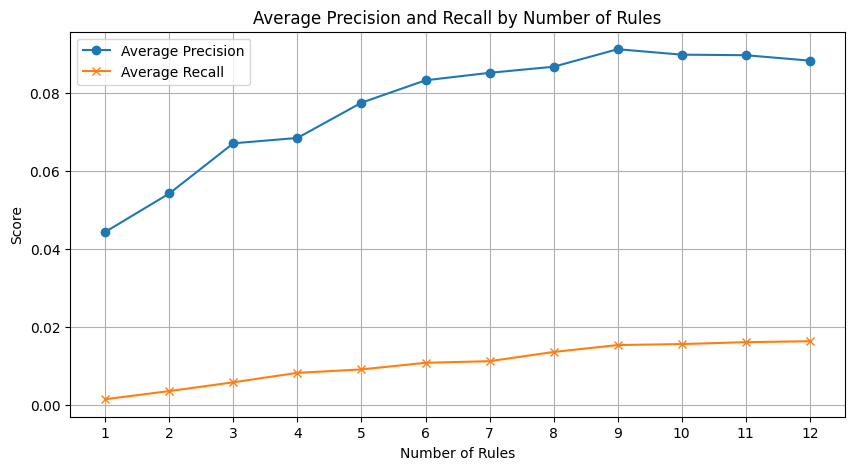

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

# Function to compute precision and recall for a single user
def evaluate_user_recommendations(user_train_movies, user_test_movies, rules, max_rules=None):
    # Limit the rules to top N (max_rules)
    if max_rules:
        filtered_rules = rules.head(max_rules)
    else:
        filtered_rules = rules

    # Filter rules where antecedents have at least one movie from user's train movies
    filtered_rules = filtered_rules[filtered_rules['antecedents'].apply(lambda x: any(movie in user_train_movies for movie in x))]

    # Get all recommended movies from the filtered rules' consequents
    recommended_movies = set(chain.from_iterable(filtered_rules['consequents']))

    # True positives: movies recommended and also in the test set
    true_positives = recommended_movies.intersection(user_test_movies)

    # Precision: Proportion of recommended movies that are in the test set
    precision = len(true_positives) / len(recommended_movies) if recommended_movies else 0

    # Recall: Proportion of test set movies that were recommended
    recall = len(true_positives) / len(user_test_movies) if user_test_movies else 0

    return precision, recall


# common_rules = top10_rules_both

# Initialize lists to store precision and recall for each user
precisions = []
recalls = []

# Iterate through each user in the test set
for index, test_row in test_df.iterrows():
    user_id = test_row['userId']

    # Get train and test movies for the current user
    user_train_movies = set(train_df[train_df['userId'] == user_id]['movieIdSet'].values[0])  # Ensure this is a set
    user_test_movies = set(test_row['movieId'])  # Ensure this is also treated as a set

    user_precisions = []
    user_recalls = []

    # Vary the number of rules from 1 to total number of common rules
    num_common_rules = len(common_rules)
    for num_rules in range(1, num_common_rules + 1):
        precision, recall = evaluate_user_recommendations(user_train_movies, user_test_movies, common_rules, max_rules=num_rules)
        user_precisions.append(precision)
        user_recalls.append(recall)

    precisions.append(user_precisions)
    recalls.append(user_recalls)

# Compute average precision and recall across all users
avg_precisions = np.mean(precisions, axis=0)
avg_recalls = np.mean(recalls, axis=0)

# Plot average precision and recall
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_common_rules + 1), avg_precisions, label='Average Precision', marker='o')
plt.plot(range(1, num_common_rules + 1), avg_recalls, label='Average Recall', marker='x')
plt.xlabel('Number of Rules')
plt.ylabel('Score')
plt.title('Average Precision and Recall by Number of Rules')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_common_rules + 1))
plt.show()

### 4. Take a sample example of users and their movie ratings from the test set and display precision and recall graphs.

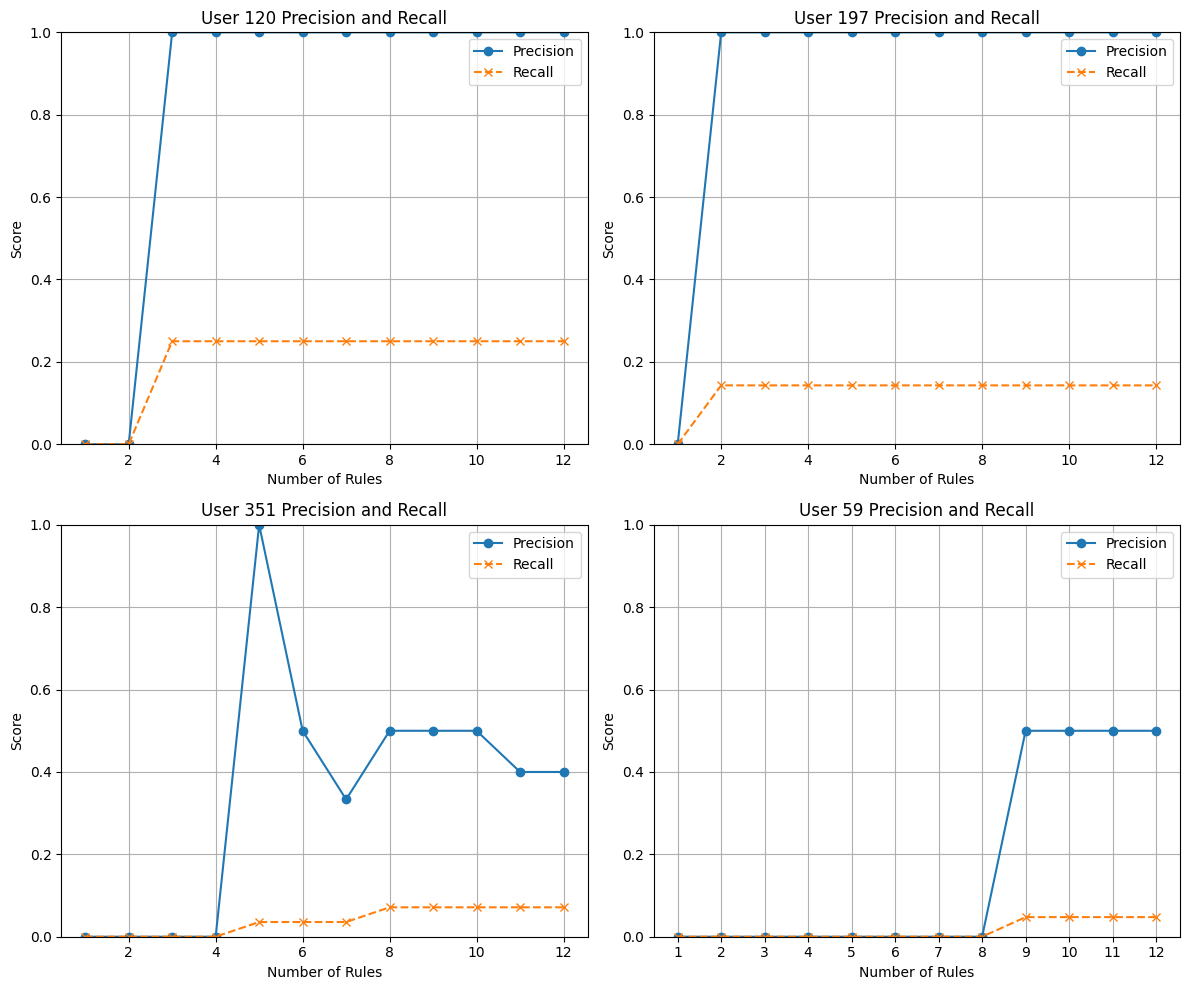

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

# Fixed list of users
sample_users = [120, 197, 351, 59]

# Initialize lists to store precision and recall for each sampled user
sampled_precisions = {}
sampled_recalls = {}

# Iterate through each sampled user
for user_id in sample_users:
    # Get train and test movies for the current user
    user_train_movies = set(train_df[train_df['userId'] == user_id]['movieIdSet'].values[0])
    user_test_movies = set(test_df[test_df['userId'] == user_id]['movieId'].values[0])

    user_precisions = []
    user_recalls = []

    # Vary the number of rules from 1 to total number of common rules
    num_common_rules = len(common_rules)
    for num_rules in range(1, num_common_rules + 1):
        precision, recall = evaluate_user_recommendations(user_train_movies, user_test_movies, common_rules, max_rules=num_rules)
        user_precisions.append(precision)
        user_recalls.append(recall)

    sampled_precisions[user_id] = user_precisions
    sampled_recalls[user_id] = user_recalls

# Create subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, user_id in enumerate(sample_users):
    ax = axs[i // 2, i % 2]  # Determine subplot position (row, column)
    ax.plot(range(1, num_common_rules + 1), sampled_precisions[user_id], label='Precision', marker='o')
    ax.plot(range(1, num_common_rules + 1), sampled_recalls[user_id], label='Recall', linestyle='--', marker='x')

    ax.set_title(f'User {user_id} Precision and Recall')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

for ax in axs.flat:
    ax.set_xlabel('Number of Rules')

plt.xticks(range(1, num_common_rules + 1))
plt.tight_layout()
plt.show()
